# Preprocessing for NLP

Library installation and importation.

In [1]:
!pip install google_trans_new
!pip install unidecode
!pip install -U spacy
!python -m spacy download es_core_news_sm
!python -m spacy download es_core_news_lg

     |████████████████████████████████| 245kB 30.0MB/s 
     |████████████████████████████████| 12.8MB 227kB/s 
     |████████████████████████████████| 460kB 35.7MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 624kB 37.7MB/s 
     |████████████████████████████████| 9.1MB 38.3MB/s 
  Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
2021-06-28 10:04:37.924696: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 13.9

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import unidecode
import gensim
import spacy
import pickle

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from gensim.models import Word2Vec

import seaborn as sns

from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from google_trans_new import google_translator 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
%cd '/content/drive/MyDrive/TFM/Preprocessing'

/content/drive/MyDrive/TFM/Preprocessing


In [4]:
SEED = 1

## Class deletion

Just take 1 class, sad.

In [5]:
emotions_df = pd.read_csv('emotions.csv')
emotions_df

,id,service,creation_datetime,date,time,ira,encantado,disgustado,tristeza,neutro,agobiado,cansado,asustado,feliz,motivado,relajado,dolor,label,social,emotion_text
0,2,das,2018-09-20 22:30:04+00:00,2018-09-20,22:29:40,0,0,0,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN
1,2,das,2018-09-24 21:15:44+00:00,2018-09-24,21:15:38,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN
2,2,das,2018-09-27 19:35:09+00:00,2018-09-27,19:35:02,0,0,0,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN
3,2,das,2018-09-28 18:36:45+00:00,2018-09-28,18:36:38,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,2,das,2018-10-03 09:01:11+00:00,2018-10-03,09:00:56,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43463,2981,ecog,2020-05-13 21:30:43+00:00,2020-05-13,21:30:27,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN
43464,2981,ecog,2020-05-28 16:47:14+00:00,2020-05-27,16:46:33,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN
43465,2981,ecog,2020-05-28 16:47:39+00:00,2020-05-27,16:47:14,0,0,0,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN
43466,2981,ecog,2020-05-28 16:46:11+00:00,2020-05-28,16:45:37,0,0,0,0,1,0,0,0,0,0,0,0,NaN,NaN,indiferente


In [6]:
daily_summary = pd.read_csv('daily_summary.csv')
print(daily_summary.shape)
daily_summary.head(5)

(671935, 30)


,id,service,date,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count
0,1,NaN,2019-07-26,NaN,NaN,1610.0,NaN,NaN,NaN,NaN,NaN,NaN,448.0,5342.0,2031.0,NaN,NaN,NaN,NaN,NaN,NaN,2059.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,2019-09-28,NaN,NaN,216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NaN,2019-10-24,NaN,NaN,1941.0,NaN,NaN,NaN,NaN,NaN,NaN,1400.0,NaN,5048.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,das,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1132.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,das,2018-06-27,NaN,NaN,NaN,NaN,NaN,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
happy = ['encantado', 'neutro', 'feliz', 'motivado', 'relajado']
sad = ['ira', 'disgustado', 'tristeza', 'agobiado', 'cansado', 'asustado', 'dolor']

In [8]:
emotions_df.insert(loc=len(emotions_df.columns), column='sad', 
                   value=(emotions_df[sad].sum(axis=1) >= 1)*1)
#emotions_df = emotions_df.drop(happy, axis=1)
#emotions_df = emotions_df.drop(sad, axis=1)
emotions_df = emotions_df.drop('service', axis=1)

In [9]:
emotions_df.head()

,id,creation_datetime,date,time,ira,encantado,disgustado,tristeza,neutro,agobiado,cansado,asustado,feliz,motivado,relajado,dolor,label,social,emotion_text,sad
0,2,2018-09-20 22:30:04+00:00,2018-09-20,22:29:40,0,0,0,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,1
1,2,2018-09-24 21:15:44+00:00,2018-09-24,21:15:38,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,1
2,2,2018-09-27 19:35:09+00:00,2018-09-27,19:35:02,0,0,0,0,0,0,1,0,0,0,0,0,NaN,NaN,NaN,1
3,2,2018-09-28 18:36:45+00:00,2018-09-28,18:36:38,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1
4,2,2018-10-03 09:01:11+00:00,2018-10-03,09:00:56,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,1


## First clean and union

For the NLP, we are going to take only the records that have associated text. 

In [10]:
text_idx = emotions_df['emotion_text'].notnull()

In [11]:
nlp_attrib = ['id', 'creation_datetime', 'date', 'time', 'emotion_text', 'sad']\
                + happy + sad
emotions_text = emotions_df[nlp_attrib].loc[text_idx]
emotions_text = emotions_text.reset_index(drop=True)

In [ ]:
print(emotions_text.shape)
emotions_text.head(5)

(6138, 18)


,id,creation_datetime,date,time,emotion_text,sad,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor
0,10,2019-04-25 11:45:47+00:00,2019-04-24,11:45:47,Vaya día.,0,0,0,1,0,0,0,0,0,0,0,0,0
1,10,2019-05-05 09:09:51+00:00,2019-05-04,09:09:51,ME HE LEVANTADO A COMER. ESTO ME FRUSTRA.,0,0,0,1,0,0,0,0,0,0,0,0,0
2,10,2019-05-06 07:40:45+00:00,2019-05-05,07:40:45,HOY ME HE DESPERTADO PERO NO HE COMIDO.,0,0,0,1,0,0,0,0,0,0,0,0,0
3,10,2019-05-07 07:47:38+00:00,2019-05-06,07:47:38,NO HE COMIDO DURANTE LA NOCHE,0,0,0,1,0,0,0,0,0,0,0,0,0
4,10,2019-05-09 13:03:21+00:00,2019-05-07,13:03:21,NO HE COMIDO.,0,0,0,1,0,0,0,0,0,0,0,0,0


### Detect the languages of the texts

Some texts are in other language than Spanish. In order to take only the Spanish texts, we are going to detect use in each observation. 

In [ ]:
translator = google_translator()

In [ ]:
rows = emotions_text['emotion_text'].values.tolist()

In [ ]:
lang = []

In [ ]:
r

In [ ]:
lang.append('es')

In [ ]:
n = len(lang)
for i in range(n, len(rows)):
    r = rows[i]
    lang.append(translator.detect(r)[0])
    if i % 100 == 0:
        print(f'{i}/{len(rows)} explored')

In [ ]:
'''with open('lang_texts.pickle', 'wb') as fp:
    pickle.dump(lang, fp)'''

In [ ]:
with open ('lang_texts.pickle', 'rb') as fp:
    lang = pickle.load(fp)
print(len(lang))
print(lang)

5959
['es', 'es', 'es', 'es', 'es', 'zh-CN', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'en', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'pt', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'pt', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'cy', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'ca', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'es', 'pt', '

In [ ]:
emotions_text['lang'] = lang

In [ ]:
spanish = emotions_text['lang'] == 'es'
emotions_text[spanish]

,id,creation_datetime,date,time,emotion_text,sad,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor,lang
0,10,2019-04-25 11:45:47+00:00,2019-04-24,11:45:47,Vaya día.,0,0,0,1,0,0,0,0,0,0,0,0,0,es
1,10,2019-05-05 09:09:51+00:00,2019-05-04,09:09:51,ME HE LEVANTADO A COMER. ESTO ME FRUSTRA.,0,0,0,1,0,0,0,0,0,0,0,0,0,es
2,10,2019-05-06 07:40:45+00:00,2019-05-05,07:40:45,HOY ME HE DESPERTADO PERO NO HE COMIDO.,0,0,0,1,0,0,0,0,0,0,0,0,0,es
3,10,2019-05-07 07:47:38+00:00,2019-05-06,07:47:38,NO HE COMIDO DURANTE LA NOCHE,0,0,0,1,0,0,0,0,0,0,0,0,0,es
4,10,2019-05-09 13:03:21+00:00,2019-05-07,13:03:21,NO HE COMIDO.,0,0,0,1,0,0,0,0,0,0,0,0,0,es
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6133,2690,2020-03-23 13:14:28+00:00,2020-03-23,13:14:01,Niñas discutiendo.,1,0,0,0,0,0,1,0,0,0,0,0,0,es
6134,2690,2020-03-23 16:06:16+00:00,2020-03-23,16:06:03,niñas en guerra,1,0,0,0,0,0,1,0,0,0,0,0,0,es
6135,2690,2020-03-27 21:11:29+00:00,2020-03-27,21:10:57,complicaciones firma trabajo,1,0,0,0,0,0,0,0,0,1,0,0,0,es
6136,2690,2020-04-14 13:14:57+00:00,2020-04-14,13:14:30,guerras de las niñas,1,0,0,0,0,0,1,0,0,0,0,0,0,es


In [ ]:
emotions_text = emotions_text[spanish]

In [ ]:
emotions_text = emotions_text.drop('lang', axis=1)

We are going to save the Spanish texts. 

In [ ]:
emotions_text.to_csv('emotions_text_clean.csv', index=False)

### Merge of app vector and text 

In [ ]:
daily_summary = daily_summary.drop('service', axis=1)
daily_summary.head(5)

,id,date,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count
0,1,2019-07-26,NaN,NaN,1610.0,NaN,NaN,NaN,NaN,NaN,NaN,448.0,5342.0,2031.0,NaN,NaN,NaN,NaN,NaN,NaN,2059.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-09-28,NaN,NaN,216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2019-10-24,NaN,NaN,1941.0,NaN,NaN,NaN,NaN,NaN,NaN,1400.0,NaN,5048.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,2016-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1132.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,2018-06-27,NaN,NaN,NaN,NaN,NaN,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
emotions_app = emotions_text.merge(daily_summary, on=['id', 'date'])
emotions_app.head(5)

,id,creation_datetime,date,time,emotion_text,sad,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count
0,10,2019-05-05 09:09:51+00:00,2019-05-04,09:09:51,ME HE LEVANTADO A COMER. ESTO ME FRUSTRA.,0,0,0,1,0,0,0,0,0,0,0,0,0,8587.1500,398.0,720.0,32400.0,22.0,NaN,8090.0,NaN,20588.0,55.0,5157.0,20603.0,NaN,NaN,2398.0,NaN,NaN,NaN,NaN,NaN,NaN,0.003554,70200.0,NaN,NaN,NaN,6.0
1,10,2019-05-06 07:40:45+00:00,2019-05-05,07:40:45,HOY ME HE DESPERTADO PERO NO HE COMIDO.,0,0,0,1,0,0,0,0,0,0,0,0,0,5796.9200,2491.0,3986.0,28800.0,28.0,NaN,2620.0,NaN,20836.0,889.0,2118.0,11749.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001379,75600.0,NaN,NaN,NaN,6.0
2,10,2019-05-07 07:47:38+00:00,2019-05-06,07:47:38,NO HE COMIDO DURANTE LA NOCHE,0,0,0,1,0,0,0,0,0,0,0,0,0,26207.2000,1111.0,1773.0,28800.0,30.0,NaN,8200.0,NaN,24300.0,280.0,8139.0,9901.0,NaN,NaN,4113.0,NaN,NaN,NaN,3109.0,NaN,NaN,0.012274,64800.0,NaN,NaN,NaN,15.0
3,10,2019-05-09 13:03:21+00:00,2019-05-07,13:03:21,NO HE COMIDO.,0,0,0,1,0,0,0,0,0,0,0,0,0,28.5104,17.0,3866.0,28800.0,38.0,NaN,8520.0,NaN,42604.0,1577.0,12109.0,16635.0,NaN,NaN,4997.0,NaN,NaN,NaN,742.0,2.0,NaN,0.000012,30600.0,NaN,NaN,NaN,2.0
4,10,2019-05-20 14:38:01+00:00,2019-05-20,14:38:01,DE VIAJE,0,0,0,1,0,0,0,0,0,0,0,0,0,4909.5400,8.0,1824.0,11958.0,NaN,NaN,4044.0,NaN,20178.0,519.0,7841.0,16960.0,NaN,NaN,4207.0,NaN,NaN,NaN,30.0,NaN,NaN,0.000013,34200.0,NaN,NaN,NaN,2.0


In [ ]:
emotions_app = emotions_app.drop(['creation_datetime', 'time'], axis=1)

In [ ]:
emotions_app.head()

,id,date,emotion_text,sad,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count
0,10,2019-05-04,ME HE LEVANTADO A COMER. ESTO ME FRUSTRA.,0,0,0,1,0,0,0,0,0,0,0,0,0,8587.1500,398.0,720.0,32400.0,22.0,NaN,8090.0,NaN,20588.0,55.0,5157.0,20603.0,NaN,NaN,2398.0,NaN,NaN,NaN,NaN,NaN,NaN,0.003554,70200.0,NaN,NaN,NaN,6.0
1,10,2019-05-05,HOY ME HE DESPERTADO PERO NO HE COMIDO.,0,0,0,1,0,0,0,0,0,0,0,0,0,5796.9200,2491.0,3986.0,28800.0,28.0,NaN,2620.0,NaN,20836.0,889.0,2118.0,11749.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001379,75600.0,NaN,NaN,NaN,6.0
2,10,2019-05-06,NO HE COMIDO DURANTE LA NOCHE,0,0,0,1,0,0,0,0,0,0,0,0,0,26207.2000,1111.0,1773.0,28800.0,30.0,NaN,8200.0,NaN,24300.0,280.0,8139.0,9901.0,NaN,NaN,4113.0,NaN,NaN,NaN,3109.0,NaN,NaN,0.012274,64800.0,NaN,NaN,NaN,15.0
3,10,2019-05-07,NO HE COMIDO.,0,0,0,1,0,0,0,0,0,0,0,0,0,28.5104,17.0,3866.0,28800.0,38.0,NaN,8520.0,NaN,42604.0,1577.0,12109.0,16635.0,NaN,NaN,4997.0,NaN,NaN,NaN,742.0,2.0,NaN,0.000012,30600.0,NaN,NaN,NaN,2.0
4,10,2019-05-20,DE VIAJE,0,0,0,1,0,0,0,0,0,0,0,0,0,4909.5400,8.0,1824.0,11958.0,NaN,NaN,4044.0,NaN,20178.0,519.0,7841.0,16960.0,NaN,NaN,4207.0,NaN,NaN,NaN,30.0,NaN,NaN,0.000013,34200.0,NaN,NaN,NaN,2.0


Save the app and text dataframe.

In [ ]:
emotions_app.to_csv('emotions_app_text.csv', index=False)

## Text cleansing

Now that we have in one dataframe the app vector with the emotion text, we are going to clean the texts. 

We are going to use SpacyMoji in order to detect what words are emoticons. 

In [ ]:
!pip install spacymoji

     |████████████████████████████████| 51kB 6.5MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp37-none-any.whl size=49734 sha256=070d02ba721a4ee9011eeb28ea50af181052c7bb1121dbbfff03ca3f68bb9796
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


In [ ]:
from spacymoji import Emoji

In [ ]:
nlp = spacy.load('es_core_news_lg')
emoji = Emoji(nlp)
nlp.add_pipe('emoji', first=True)

Load the emotion app with text dataset. 

In [ ]:
emotion_app = pd.read_csv('emotions_app_text.csv')

In [ ]:
emotion_app.head(5)

,id,date,emotion_text,sad,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count
0,10,2019-05-04,ME HE LEVANTADO A COMER. ESTO ME FRUSTRA.,0,0,0,1,0,0,0,0,0,0,0,0,0,8587.1500,398.0,720.0,32400.0,22.0,NaN,8090.0,NaN,20588.0,55.0,5157.0,20603.0,NaN,NaN,2398.0,NaN,NaN,NaN,NaN,NaN,NaN,0.003554,70200.0,NaN,NaN,NaN,6.0
1,10,2019-05-05,HOY ME HE DESPERTADO PERO NO HE COMIDO.,0,0,0,1,0,0,0,0,0,0,0,0,0,5796.9200,2491.0,3986.0,28800.0,28.0,NaN,2620.0,NaN,20836.0,889.0,2118.0,11749.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001379,75600.0,NaN,NaN,NaN,6.0
2,10,2019-05-06,NO HE COMIDO DURANTE LA NOCHE,0,0,0,1,0,0,0,0,0,0,0,0,0,26207.2000,1111.0,1773.0,28800.0,30.0,NaN,8200.0,NaN,24300.0,280.0,8139.0,9901.0,NaN,NaN,4113.0,NaN,NaN,NaN,3109.0,NaN,NaN,0.012274,64800.0,NaN,NaN,NaN,15.0
3,10,2019-05-07,NO HE COMIDO.,0,0,0,1,0,0,0,0,0,0,0,0,0,28.5104,17.0,3866.0,28800.0,38.0,NaN,8520.0,NaN,42604.0,1577.0,12109.0,16635.0,NaN,NaN,4997.0,NaN,NaN,NaN,742.0,2.0,NaN,0.000012,30600.0,NaN,NaN,NaN,2.0
4,10,2019-05-20,DE VIAJE,0,0,0,1,0,0,0,0,0,0,0,0,0,4909.5400,8.0,1824.0,11958.0,NaN,NaN,4044.0,NaN,20178.0,519.0,7841.0,16960.0,NaN,NaN,4207.0,NaN,NaN,NaN,30.0,NaN,NaN,0.000013,34200.0,NaN,NaN,NaN,2.0


In [ ]:
emotion_app['emotion_text'] = emotion_app.emotion_text.str.lower()

In [ ]:
emotion_app.head(5)

,id,date,emotion_text,sad,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count
0,10,2019-05-04,me he levantado a comer. esto me frustra.,0,0,0,1,0,0,0,0,0,0,0,0,0,8587.1500,398.0,720.0,32400.0,22.0,NaN,8090.0,NaN,20588.0,55.0,5157.0,20603.0,NaN,NaN,2398.0,NaN,NaN,NaN,NaN,NaN,NaN,0.003554,70200.0,NaN,NaN,NaN,6.0
1,10,2019-05-05,hoy me he despertado pero no he comido.,0,0,0,1,0,0,0,0,0,0,0,0,0,5796.9200,2491.0,3986.0,28800.0,28.0,NaN,2620.0,NaN,20836.0,889.0,2118.0,11749.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001379,75600.0,NaN,NaN,NaN,6.0
2,10,2019-05-06,no he comido durante la noche,0,0,0,1,0,0,0,0,0,0,0,0,0,26207.2000,1111.0,1773.0,28800.0,30.0,NaN,8200.0,NaN,24300.0,280.0,8139.0,9901.0,NaN,NaN,4113.0,NaN,NaN,NaN,3109.0,NaN,NaN,0.012274,64800.0,NaN,NaN,NaN,15.0
3,10,2019-05-07,no he comido.,0,0,0,1,0,0,0,0,0,0,0,0,0,28.5104,17.0,3866.0,28800.0,38.0,NaN,8520.0,NaN,42604.0,1577.0,12109.0,16635.0,NaN,NaN,4997.0,NaN,NaN,NaN,742.0,2.0,NaN,0.000012,30600.0,NaN,NaN,NaN,2.0
4,10,2019-05-20,de viaje,0,0,0,1,0,0,0,0,0,0,0,0,0,4909.5400,8.0,1824.0,11958.0,NaN,NaN,4044.0,NaN,20178.0,519.0,7841.0,16960.0,NaN,NaN,4207.0,NaN,NaN,NaN,30.0,NaN,NaN,0.000013,34200.0,NaN,NaN,NaN,2.0


For cleaning the text, we are just going to take the lemma of the words that are in the dictionary, are not punctuation and Spanish stopwords. 

In [ ]:
doc = nlp('Yo no levantarme a el comer los niños')

In [ ]:
[token.pos_ for token in doc if not token.is_oov]

['PRON', 'ADV', 'VERB', 'ADP', 'DET', 'VERB', 'DET', 'NOUN']

In [ ]:
def clean_text(nlp, text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token._.is_emoji 
              and not token.is_punct and not token.is_oov 
              and token.pos_ != 'ADP' and token.pos_ != 'DET' and 
              token.pos_ != 'PRON' and token.pos_ != 'AUX']
    return " ".join(tokens)

In [ ]:
emotion_app['emotion_text'] = emotion_app['emotion_text'].apply(lambda x: clean_text(nlp, x))

In [ ]:
emotion_app.head(5)

,id,date,emotion_text,sad,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count
0,10,2019-05-04,levantar comer frustrar,0,0,0,1,0,0,0,0,0,0,0,0,0,8587.1500,398.0,720.0,32400.0,22.0,NaN,8090.0,NaN,20588.0,55.0,5157.0,20603.0,NaN,NaN,2398.0,NaN,NaN,NaN,NaN,NaN,NaN,0.003554,70200.0,NaN,NaN,NaN,6.0
1,10,2019-05-05,hoy despertar pero no comer,0,0,0,1,0,0,0,0,0,0,0,0,0,5796.9200,2491.0,3986.0,28800.0,28.0,NaN,2620.0,NaN,20836.0,889.0,2118.0,11749.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001379,75600.0,NaN,NaN,NaN,6.0
2,10,2019-05-06,no comer noche,0,0,0,1,0,0,0,0,0,0,0,0,0,26207.2000,1111.0,1773.0,28800.0,30.0,NaN,8200.0,NaN,24300.0,280.0,8139.0,9901.0,NaN,NaN,4113.0,NaN,NaN,NaN,3109.0,NaN,NaN,0.012274,64800.0,NaN,NaN,NaN,15.0
3,10,2019-05-07,no comer,0,0,0,1,0,0,0,0,0,0,0,0,0,28.5104,17.0,3866.0,28800.0,38.0,NaN,8520.0,NaN,42604.0,1577.0,12109.0,16635.0,NaN,NaN,4997.0,NaN,NaN,NaN,742.0,2.0,NaN,0.000012,30600.0,NaN,NaN,NaN,2.0
4,10,2019-05-20,viaje,0,0,0,1,0,0,0,0,0,0,0,0,0,4909.5400,8.0,1824.0,11958.0,NaN,NaN,4044.0,NaN,20178.0,519.0,7841.0,16960.0,NaN,NaN,4207.0,NaN,NaN,NaN,30.0,NaN,NaN,0.000013,34200.0,NaN,NaN,NaN,2.0


In [ ]:
def clean_text_check(nlp, text):
    doc = nlp(text)
    tokens = [token for token in doc if not token._.is_emoji 
              and not token.is_punct and not token.is_oov 
              and token.pos_ != 'ADP' and token.pos_ != 'DET' and 
              token.pos_ != 'PRON' and token.pos_ != 'AUX']
    return " ".join(tokens)

In [ ]:
emotion_app['emotion_text'] = emotion_app['emotion_text'].apply(lambda x: clean_text(nlp, x))

In [ ]:
doc = nlp(emotion_app['emotion_text'].loc[39])
for token in doc:
    print(token.text, token.is_oov)

no False
salir False
casa False
no False
coger False
tlf False
no False
como False
no False
solo False
cana False


In [ ]:
emotion_app.to_csv('emotions_app_text_clean.csv', index=False)

In [ ]:
emotion_app

,id,date,emotion_text,sad,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count
0,10,2019-05-04,levantar comer frustrar,0,0,0,1,0,0,0,0,0,0,0,0,0,8587.1500,398.0,720.0,32400.0,22.0,NaN,8090.0,NaN,20588.0,55.0,5157.0,20603.0,NaN,NaN,2398.0,NaN,NaN,NaN,NaN,NaN,NaN,0.003554,70200.0,NaN,NaN,NaN,6.0
1,10,2019-05-05,hoy despertar pero no comer,0,0,0,1,0,0,0,0,0,0,0,0,0,5796.9200,2491.0,3986.0,28800.0,28.0,NaN,2620.0,NaN,20836.0,889.0,2118.0,11749.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001379,75600.0,NaN,NaN,NaN,6.0
2,10,2019-05-06,no comer noche,0,0,0,1,0,0,0,0,0,0,0,0,0,26207.2000,1111.0,1773.0,28800.0,30.0,NaN,8200.0,NaN,24300.0,280.0,8139.0,9901.0,NaN,NaN,4113.0,NaN,NaN,NaN,3109.0,NaN,NaN,0.012274,64800.0,NaN,NaN,NaN,15.0
3,10,2019-05-07,no comer,0,0,0,1,0,0,0,0,0,0,0,0,0,28.5104,17.0,3866.0,28800.0,38.0,NaN,8520.0,NaN,42604.0,1577.0,12109.0,16635.0,NaN,NaN,4997.0,NaN,NaN,NaN,742.0,2.0,NaN,0.000012,30600.0,NaN,NaN,NaN,2.0
4,10,2019-05-20,viaje,0,0,0,1,0,0,0,0,0,0,0,0,0,4909.5400,8.0,1824.0,11958.0,NaN,NaN,4044.0,NaN,20178.0,519.0,7841.0,16960.0,NaN,NaN,4207.0,NaN,NaN,NaN,30.0,NaN,NaN,0.000013,34200.0,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5208,2690,2020-03-11,día,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,25800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,NaN,NaN
5209,2690,2020-03-23,niña discutir,1,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,23400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN
5210,2690,2020-03-23,niña guerra,1,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,23400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN
5211,2690,2020-03-27,complicación firmo trabajo,1,0,0,0,0,0,0,0,0,1,0,0,0,641.4610,NaN,5413.0,42000.0,NaN,NaN,NaN,NaN,NaN,5295.0,NaN,28367.0,0.0,554.0,608.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,0.0,554.0,NaN


## Length cleaning

There are cases where the text is too long, we are going to take just the 15 first words of the text that are larger than that number. 

In [12]:
emotions_text = pd.read_csv('emotions_app_text_clean.csv')
emotions_text

,id,date,emotion_text,sad,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count
0,10,2019-05-04,levantar comer frustrar,0,0,0,1,0,0,0,0,0,0,0,0,0,8587.1500,398.0,720.0,32400.0,22.0,NaN,8090.0,NaN,20588.0,55.0,5157.0,20603.0,NaN,NaN,2398.0,NaN,NaN,NaN,NaN,NaN,NaN,0.003554,70200.0,NaN,NaN,NaN,6.0
1,10,2019-05-05,hoy despertar pero no comer,0,0,0,1,0,0,0,0,0,0,0,0,0,5796.9200,2491.0,3986.0,28800.0,28.0,NaN,2620.0,NaN,20836.0,889.0,2118.0,11749.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001379,75600.0,NaN,NaN,NaN,6.0
2,10,2019-05-06,no comer noche,0,0,0,1,0,0,0,0,0,0,0,0,0,26207.2000,1111.0,1773.0,28800.0,30.0,NaN,8200.0,NaN,24300.0,280.0,8139.0,9901.0,NaN,NaN,4113.0,NaN,NaN,NaN,3109.0,NaN,NaN,0.012274,64800.0,NaN,NaN,NaN,15.0
3,10,2019-05-07,no comer,0,0,0,1,0,0,0,0,0,0,0,0,0,28.5104,17.0,3866.0,28800.0,38.0,NaN,8520.0,NaN,42604.0,1577.0,12109.0,16635.0,NaN,NaN,4997.0,NaN,NaN,NaN,742.0,2.0,NaN,0.000012,30600.0,NaN,NaN,NaN,2.0
4,10,2019-05-20,viaje,0,0,0,1,0,0,0,0,0,0,0,0,0,4909.5400,8.0,1824.0,11958.0,NaN,NaN,4044.0,NaN,20178.0,519.0,7841.0,16960.0,NaN,NaN,4207.0,NaN,NaN,NaN,30.0,NaN,NaN,0.000013,34200.0,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5208,2690,2020-03-11,día,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,25800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,NaN,NaN
5209,2690,2020-03-23,niña discutir,1,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,23400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN
5210,2690,2020-03-23,niña guerra,1,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,23400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN
5211,2690,2020-03-27,complicación firmo trabajo,1,0,0,0,0,0,0,0,0,1,0,0,0,641.4610,NaN,5413.0,42000.0,NaN,NaN,NaN,NaN,NaN,5295.0,NaN,28367.0,0.0,554.0,608.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,0.0,554.0,NaN


In [13]:
def number_words(text):
    return len(text.split(' '))

In [14]:
app_text = emotions_text['emotion_text'].astype(str)
emotion_text_lenghts = app_text.map(number_words)

In [15]:
emotion_text_lenghts = pd.DataFrame(emotion_text_lenghts)
emotion_text_lenghts = emotion_text_lenghts.rename(columns={'emotion_text': 'text_length'})
emotion_text_lenghts['sad'] = emotions_text['sad']

In [16]:
print(f'{np.sum(emotion_text_lenghts.text_length > 15)}/{app_text.shape[0]}')

621/5213


In [ ]:
max(emotion_text_lenghts.text_length)

421

In [ ]:
emotion_text_lenghts

,text_length,sad
0,3,0
1,5,0
2,3,0
3,2,0
4,1,0
...,...,...
5208,1,0
5209,2,1
5210,2,1
5211,3,1


In [ ]:
ListedColormap(['yellowgreen', 'tomato'])

In [ ]:
colors = list([sns.color_palette("Paired")[3], sns.color_palette("Paired")[5]])

In [ ]:
palette = list([sns.color_palette("Paired")[3], sns.color_palette("Paired")[5]])

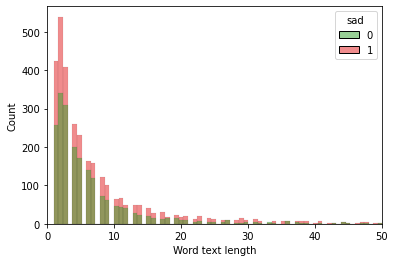

In [ ]:
sns.histplot(data=emotion_text_lenghts, x='text_length', hue='sad',
             palette=palette)
plt.xlim(0, 50)
plt.xlabel('Word text length')
plt.savefig('text_length.png', dpi=300)

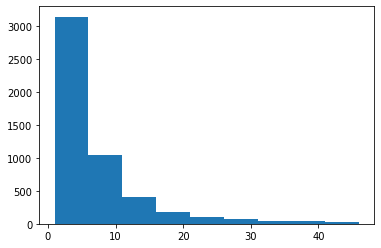

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.hist(emotion_text_lenghts, bins=range(1, 50, 5))
plt.show()

In [ ]:
app_text[36]

'muuuy cansado último analítico salir hierro 18 creer que mínimo 50 y acabar tener regla dormir 10-11 hora tb desanimado tener trabajo pero después boda y viaje quedar hacer'

In [ ]:
app_text.loc[emotion_text_lenghts > 20]

21      hoy sentir cansado no dormir bien ni descanso ...
35      ir centro dia hacer programado andar y no tene...
36      muuuy cansado último analítico salir hierro 18...
91      bueno día movidito trabajo llegar casa y reuni...
105     hermana decidir volver centro y que volver lia...
                              ...                        
5095    tema pasar realidad no pasar pero dia 3de cuar...
5189    ansiedad vez meter lio pueblo concejal cultura...
5192    lur volver atacar ro que matar ahora atado jar...
5194    echar falta emoticono nervioso intentar no tom...
5203    tiempo confinado trabajar jardín y positivo no...
Name: emotion_text, Length: 436, dtype: object

We are going to keep just the first 15 words of each emotion text. 

In [ ]:
def clean_text(text):
    words = text.split(' ')
    if len(words) <= 20 :
        return text
    else: 
        return " ".join(words[:20])

In [ ]:
app_text_length_clean = app_text.map(clean_text)

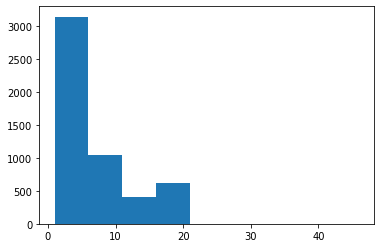

In [ ]:
emotion_text_lenghts = app_text_length_clean.map(number_words)
plt.hist(emotion_text_lenghts, bins=range(1, 50, 5))
plt.show()

In [ ]:
emotions_text.emotion_text[emotion_text_lenghts == 20].values[:10]

array(['hoy sentir cansado no dormir bien ni descanso y notar día y preocupado vez tema económico y hijo ver que quedar bloqueado estudio',
       'ir centro dia hacer programado andar y no tener que venir pues ir casa porque complir venir y no y luego monitor hecho bronca',
       'muuuy cansado último analítico salir hierro 18 creer que mínimo 50 y acabar tener regla dormir 10-11 hora tb desanimado tener trabajo pero después boda y viaje quedar hacer',
       'bueno día movidito trabajo llegar casa y reunión comunidad aclamación popular volver vicepresidente comunidad cargo heredé madre y como verdad que gustar pero que dejar tranquilito además secretaria mancomunidad aunque total allí sólo hablar no hacer productivo',
       'hermana decidir volver centro y que volver liar hoy 12 mañana vecino poner taladro pues levantar que ir mierda vecino siempre obra disgustar y sentar mal así que liar y tarde amiga',
       'no si preocupado definición exacto medicación comer sitio no tener var

In [ ]:
emotions_text['emotion_text'] = app_text_length_clean

In [ ]:
emotions_text.to_csv('emotions_app_clean_length_20_emotion_sum.csv', index=False)

In [ ]:
app_vector_attr = emotions_text.columns[4:]
app_vector = emotions_text[app_vector_attr].copy()
app_vector = app_vector.fillna(0)
app_records[app_vector_attr] = app_vector

In [ ]:
app_records = app_records.dropna()

In [ ]:
attr_nans = emotions_text.columns[16:]

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
iter = IterativeImputer().fit(emotions_text[attr_nans])
emotions_text[attr_nans] = iter.transform(emotions_text[attr_nans])

In [ ]:
emotions_text.to_csv('app_records_cleaned_10_iter.csv', index=False)

In [ ]:
app_records.to_csv('app_records_cleaned.csv', index=False)

## Words selection acc. frequence

We are going to delete the words that have appeared less than 10 times. 

In [ ]:
app_records = pd.read_csv('app_records_cleaned.csv')
app_records

,id,date,emotion_text,sad,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count
0,10,2019-05-04,levantar comer frustrar,0,0,0,1,0,0,0,0,0,0,0,0,0,8587.1500,398.0,720.0,32400.0,22.0,0.0,8090.0,0.0,20588.0,55.0,5157.0,20603.0,0.0,0.0,2398.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003554,70200.0,0.0,0.0,0.0,6.0
1,10,2019-05-05,hoy despertar pero no comer,0,0,0,1,0,0,0,0,0,0,0,0,0,5796.9200,2491.0,3986.0,28800.0,28.0,0.0,2620.0,0.0,20836.0,889.0,2118.0,11749.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001379,75600.0,0.0,0.0,0.0,6.0
2,10,2019-05-06,no comer noche,0,0,0,1,0,0,0,0,0,0,0,0,0,26207.2000,1111.0,1773.0,28800.0,30.0,0.0,8200.0,0.0,24300.0,280.0,8139.0,9901.0,0.0,0.0,4113.0,0.0,0.0,0.0,3109.0,0.0,0.0,0.012274,64800.0,0.0,0.0,0.0,15.0
3,10,2019-05-07,no comer,0,0,0,1,0,0,0,0,0,0,0,0,0,28.5104,17.0,3866.0,28800.0,38.0,0.0,8520.0,0.0,42604.0,1577.0,12109.0,16635.0,0.0,0.0,4997.0,0.0,0.0,0.0,742.0,2.0,0.0,0.000012,30600.0,0.0,0.0,0.0,2.0
4,10,2019-05-20,viaje,0,0,0,1,0,0,0,0,0,0,0,0,0,4909.5400,8.0,1824.0,11958.0,0.0,0.0,4044.0,0.0,20178.0,519.0,7841.0,16960.0,0.0,0.0,4207.0,0.0,0.0,0.0,30.0,0.0,0.0,0.000013,34200.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5156,2690,2020-03-11,día,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0000,0.0,0.0,25800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,4.0,0.0,0.0,0.0
5157,2690,2020-03-23,niña discutir,1,0,0,0,0,0,1,0,0,0,0,0,0,0.0000,0.0,0.0,23400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3.0,0.0,0.0,0.0
5158,2690,2020-03-23,niña guerra,1,0,0,0,0,0,1,0,0,0,0,0,0,0.0000,0.0,0.0,23400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3.0,0.0,0.0,0.0
5159,2690,2020-03-27,complicación firmo trabajo,1,0,0,0,0,0,0,0,0,1,0,0,0,641.4610,0.0,5413.0,42000.0,0.0,0.0,0.0,0.0,0.0,5295.0,0.0,28367.0,0.0,554.0,608.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.0,1.0,0.0,554.0,0.0


In [ ]:
app_records['emotion_text'] = app_records['emotion_text'].astype(str)

In [ ]:
len(set(app_records['emotion_text'].str.cat().split(' ')))

6886

In [ ]:
emotion_text_lenghts = app_records['emotion_text']\
                        .map(lambda x: len(x.split(' ')))
print('Max #words in a sentence:', max(emotion_text_lenghts))

Max #words in a sentence: 15


In [ ]:
corpus = app_records['emotion_text'].str.split(' ').values.tolist()

In [ ]:
embed = Word2Vec(sentences=corpus, size=50, window=5, min_count=10, sg=1, 
                     seed=SEED)

In [ ]:
vocab_list = list(embed.wv.vocab.keys())
len(vocab_list)

422

In [ ]:
def clean_text_vocab(vocab_list, text):
    words = text.split(' ')
    words_clean = [w for w in words if w in vocab_list]
    return ' '.join(words_clean)

In [ ]:
sentence = app_records['emotion_text'].loc[0]
words = sentence.split(' ')
clean_sentence = ' '.join([w for w in words if w in vocab_list])
print(sentence, '-', clean_sentence)

levantar comer frustrar - levantar comer


In [ ]:
app_text_clean = app_records['emotion_text']\
                    .map(lambda x: clean_text_vocab(vocab_list, x))

In [ ]:
app_records['emotion_text'] = app_text_clean

In [ ]:
np.sum(app_records.isnull())

id                0
date              0
emotion_text      0
sad               0
encantado         0
neutro            0
feliz             0
motivado          0
relajado          0
ira               0
disgustado        0
tristeza          0
agobiado          0
cansado           0
asustado          0
dolor             0
distance          0
steps_home        0
steps_total       0
sleep             0
sleep_quality     0
calls             0
social_usage      0
games_usage       0
app_usage         0
walking           0
tilting           0
still             0
running           0
sport             0
vehicle           0
acrophase         0
mesor             0
amplitude         0
start_move        0
stability         0
behavior          0
gyradius          0
home_cluster      0
emotions_count    0
emotions_ratio    0
biking            0
clusters_count    0
dtype: int64

In [ ]:
app_records.to_csv('app_records_word_freq_cleaned.csv', index=False)

## Class cleaning

In [ ]:
app_records = pd.read_csv('emotions_app_text_clean.csv')
app_records

,id,date,emotion_text,sad,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count
0,10,2019-05-04,levantar comer frustrar,0,0,0,1,0,0,0,0,0,0,0,0,0,8587.1500,398.0,720.0,32400.0,22.0,NaN,8090.0,NaN,20588.0,55.0,5157.0,20603.0,NaN,NaN,2398.0,NaN,NaN,NaN,NaN,NaN,NaN,0.003554,70200.0,NaN,NaN,NaN,6.0
1,10,2019-05-05,hoy despertar pero no comer,0,0,0,1,0,0,0,0,0,0,0,0,0,5796.9200,2491.0,3986.0,28800.0,28.0,NaN,2620.0,NaN,20836.0,889.0,2118.0,11749.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001379,75600.0,NaN,NaN,NaN,6.0
2,10,2019-05-06,no comer noche,0,0,0,1,0,0,0,0,0,0,0,0,0,26207.2000,1111.0,1773.0,28800.0,30.0,NaN,8200.0,NaN,24300.0,280.0,8139.0,9901.0,NaN,NaN,4113.0,NaN,NaN,NaN,3109.0,NaN,NaN,0.012274,64800.0,NaN,NaN,NaN,15.0
3,10,2019-05-07,no comer,0,0,0,1,0,0,0,0,0,0,0,0,0,28.5104,17.0,3866.0,28800.0,38.0,NaN,8520.0,NaN,42604.0,1577.0,12109.0,16635.0,NaN,NaN,4997.0,NaN,NaN,NaN,742.0,2.0,NaN,0.000012,30600.0,NaN,NaN,NaN,2.0
4,10,2019-05-20,viaje,0,0,0,1,0,0,0,0,0,0,0,0,0,4909.5400,8.0,1824.0,11958.0,NaN,NaN,4044.0,NaN,20178.0,519.0,7841.0,16960.0,NaN,NaN,4207.0,NaN,NaN,NaN,30.0,NaN,NaN,0.000013,34200.0,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5208,2690,2020-03-11,día,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,25800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,NaN,NaN
5209,2690,2020-03-23,niña discutir,1,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,23400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN
5210,2690,2020-03-23,niña guerra,1,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,23400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN
5211,2690,2020-03-27,complicación firmo trabajo,1,0,0,0,0,0,0,0,0,1,0,0,0,641.4610,NaN,5413.0,42000.0,NaN,NaN,NaN,NaN,NaN,5295.0,NaN,28367.0,0.0,554.0,608.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,0.0,554.0,NaN


In [ ]:
emotion_sum_attr = app_records.columns[4:16]
emotion_sum_attr

Index(['encantado', 'neutro', 'feliz', 'motivado', 'relajado', 'ira',
       'disgustado', 'tristeza', 'agobiado', 'cansado', 'asustado', 'dolor'],
      dtype='object')

In [ ]:
print('Rows with 2 classes at the same time:', 
      np.sum(np.sum(app_records[emotion_sum_attr], axis=1) == 0))

Rows with 2 classes at the same time: 40


In [ ]:
idxs = np.sum(app_records[emotion_sum_attr], axis=1) == 0
idxs = np.where(idxs==True)[0]

In [ ]:
for ii, i in enumerate(idxs):
    print(f'Row: {ii}/{len(idxs)}')
    row = app_records.loc[i]
    print(row['emotion_text'])
    print(row[emotion_sum_attr])
    best_class = input('Select what is the best class: ')
    app_records.loc[i, emotion_sum_attr] = 0
    app_records.loc[i, best_class] = 1
    print()

Row: 0/40
feliz y alegre
encantado     0
neutro        0
feliz         0
motivado      0
relajado      0
ira           0
disgustado    0
tristeza      0
agobiado      0
cansado       0
asustado      0
dolor         0
Name: 25, dtype: object


KeyboardInterrupt: ignored

In [ ]:
app_records.to_csv('app_records_class_cleaned.csv', index=False)

In [ ]:
app_records = pd.read_csv('app_records_class_cleaned.csv')

In [ ]:
app_records['emotion_text'] = app_records['emotion_text'].astype(str)

In [ ]:
app_records.head(3)

,id,date,emotion_text,sad,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count,digustado,disgutado,geliz
0,10,2019-05-04,levantar comer frustrar,0,0,0,1,0,0,0,0,0,0,0,0,0,8587.15,398.0,720.0,32400.0,22.0,NaN,8090.0,NaN,20588.0,55.0,5157.0,20603.0,NaN,NaN,2398.0,NaN,NaN,NaN,NaN,NaN,NaN,0.003554,70200.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN
1,10,2019-05-05,hoy despertar pero no comer,0,0,0,1,0,0,0,0,0,0,0,0,0,5796.92,2491.0,3986.0,28800.0,28.0,NaN,2620.0,NaN,20836.0,889.0,2118.0,11749.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001379,75600.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN
2,10,2019-05-06,no comer noche,0,0,0,1,0,0,0,0,0,0,0,0,0,26207.20,1111.0,1773.0,28800.0,30.0,NaN,8200.0,NaN,24300.0,280.0,8139.0,9901.0,NaN,NaN,4113.0,NaN,NaN,NaN,3109.0,NaN,NaN,0.012274,64800.0,NaN,NaN,NaN,15.0,NaN,NaN,NaN


In [ ]:
app_records = app_records.drop(labels=['digustado', 'disgutado', 'geliz'], axis=1)

In [ ]:
max_words = len(max(app_records['emotion_text'], key=lambda x: len(x.split())).split())
print("Maximum number of words in a text:", max_words)

Maximum number of words in a text: 20


In [ ]:
app_records

,id,date,emotion_text,sad,encantado,neutro,feliz,motivado,relajado,ira,disgustado,tristeza,agobiado,cansado,asustado,dolor,distance,steps_home,steps_total,sleep,sleep_quality,calls,social_usage,games_usage,app_usage,walking,tilting,still,running,sport,vehicle,acrophase,mesor,amplitude,start_move,stability,behavior,gyradius,home_cluster,emotions_count,emotions_ratio,biking,clusters_count
0,10,2019-05-04,levantar comer frustrar,0,0,0,1,0,0,0,0,0,0,0,0,0,8587.1500,398.0,720.0,32400.0,22.0,NaN,8090.0,NaN,20588.0,55.0,5157.0,20603.0,NaN,NaN,2398.0,NaN,NaN,NaN,NaN,NaN,NaN,0.003554,70200.0,NaN,NaN,NaN,6.0
1,10,2019-05-05,hoy despertar pero no comer,0,0,0,1,0,0,0,0,0,0,0,0,0,5796.9200,2491.0,3986.0,28800.0,28.0,NaN,2620.0,NaN,20836.0,889.0,2118.0,11749.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001379,75600.0,NaN,NaN,NaN,6.0
2,10,2019-05-06,no comer noche,0,0,0,1,0,0,0,0,0,0,0,0,0,26207.2000,1111.0,1773.0,28800.0,30.0,NaN,8200.0,NaN,24300.0,280.0,8139.0,9901.0,NaN,NaN,4113.0,NaN,NaN,NaN,3109.0,NaN,NaN,0.012274,64800.0,NaN,NaN,NaN,15.0
3,10,2019-05-07,no comer,0,0,0,1,0,0,0,0,0,0,0,0,0,28.5104,17.0,3866.0,28800.0,38.0,NaN,8520.0,NaN,42604.0,1577.0,12109.0,16635.0,NaN,NaN,4997.0,NaN,NaN,NaN,742.0,2.0,NaN,0.000012,30600.0,NaN,NaN,NaN,2.0
4,10,2019-05-20,viaje,0,0,0,1,0,0,0,0,0,0,0,0,0,4909.5400,8.0,1824.0,11958.0,NaN,NaN,4044.0,NaN,20178.0,519.0,7841.0,16960.0,NaN,NaN,4207.0,NaN,NaN,NaN,30.0,NaN,NaN,0.000013,34200.0,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5208,2690,2020-03-11,día,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,25800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,NaN,NaN
5209,2690,2020-03-23,niña discutir,1,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,23400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN
5210,2690,2020-03-23,niña guerra,1,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,23400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,NaN
5211,2690,2020-03-27,complicación firmo trabajo,1,0,0,0,0,0,0,0,0,1,0,0,0,641.4610,NaN,5413.0,42000.0,NaN,NaN,NaN,NaN,NaN,5295.0,NaN,28367.0,0.0,554.0,608.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,0.0,554.0,NaN


## Playing with SpaCy

In [ ]:
doc = nlp(emotion_app.loc[12].emotion_text)
a = [(token, token.is_oov) for token in doc]

Obtain the vocabulary that SpaCy is using. 

In [ ]:
spacy.vocab

<module 'spacy.vocab' from '/usr/local/lib/python3.7/dist-packages/spacy/vocab.cpython-37m-x86_64-linux-gnu.so'>

Obtain the word representation. If that word is not in the dictionary, it returns all 0s. 

In [ ]:
manzana_v = nlp.vocab.get_vector("manzana")

NameError: ignored

In [ ]:
manzana_v.reshape(1, 300).shape

NameError: ignored

In [ ]:
doc.vocab.vectors.most_similar()

Obtain the most similar word of that word vector. 

In [ ]:
nlp.vocab.vectors.most_similar(manzana_v.reshape(1, 300), n=1)

(array([[4982310742655693496]], dtype=uint64),
 array([[7046]], dtype=int32),
 array([[1.]], dtype=float32))

Whether we look for that number in the vocabulary, we get the word. 

In [ ]:
nlp.vocab.strings[4982310742655693496]

'manzana'